# Binary classifier of Spurious Closure of DHSV

This is an **example** of how to use the 3W toolkit, a software package written in Python 3 that contains resources that make the following easier:

* 3W dataset overview generation;
* Experimentation and comparative analysis of Machine Learning-based approaches and algorithms for specific problems related to undesirable events that occur in offshore oil wells during their respective production phases;
* Standardization of key points of the Machine Learning-based algorithm development pipeline.

The 3W toolkit and the 3W dataset are major resources that compose the 3W project, a pilot of a Petrobras' program called [Conexões para Inovação - Módulo Open Lab](https://prd.hotsitespetrobras.com.br/pt/nossas-atividades/tecnologia-e-inovacao/conexoes-para-inovacao/) that promotes experimentation of Machine Learning-based approaches and algorithms for specific problems related to undesirable events that occur in offshore oil wells.

# 1. Introduction

This [Jupyter Notebooks](https://jupyter.org/) presents a **basic** example of how to use the 3W toolkit's resources to develop an experiment for a specific problem.

You can adapt this example to experiment other approaches. To do so, follow the instructions included in the following codes as comments.

**IMPORTANT**: in order to experiment very different approaches with other Machine Learning pipelines, we need to evolve the 3W toolkit first. Your help with this is greatly appreciated.

# 2. Imports and Configurations

In [1]:
import sys
import os
import numpy as np
import collections
import sklearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing
import pandas as pd
from sklearn.utils import shuffle
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid


sys.path.append(os.path.join('..','..','..'))
import toolkit as tk
import collections 
import keras.backend as K

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 3. Creating an Experiment for a Specific Problem

A specific event type defined in the `dataset\dataset.ini` must be used as `event_name` when we create a experiment.

In [2]:
experiment = tk.Experiment(event_name="SPURIOUS_CLOSURE_OF_DHSV",forca_binario=True)

# 4. Setting up Folds for an Experiment

As the 3W toolkit defines and standardizes a number of things, we don't need to worry about labels and IDs associated with the specific event type chosen, number of folds, and which folds consider which instances.

In [3]:
event_labels = list(experiment.event_labels.values())
event_labels_idx = {v: i for i, v in enumerate(event_labels)}
fold: tk.EventFold
folds: tk.EventFolds = experiment.folds()

Loading instances <●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●> 150/150 [100%] in 16.3s (9.18/s)                           


Hyperparameters (kernel_size, filters, the usage of BatchNorm) 

# 5. Executing an Experiment

In [4]:
def preprocess_data(X_train, y_train,X_test) :
    # Pré-processamento
    #
    # X_train - list of ndarray 
    # y_train - list
    # X_test - list of ndarray
    n_observations = X_train[0].shape[0]
    n_features = X_train[0].shape[1]

    #Resample the training dataset due to imbalance
    rus = RandomUnderSampler(random_state=42)
    rus.sampling_strategy="not minority" 
    X_train_arr = np.array(X_train) 
    X_test_arr = np.array(X_test)          
    X_train_arr = X_train_arr.reshape(len(X_train),n_observations*n_features) #  Matrix containing the data which have to be sampled shape : (n_samples, n_features)
    # X_res : ndarray of training data resampled
    # y_res : list of training data resampled
    X_res, y_res = rus.fit_resample(X_train_arr, y_train) 
    n_train_samples = X_res.shape[0]
    X_res = X_res.reshape(n_train_samples,n_observations,n_features) # (n_samples, n_observations , n_features)
    X_test_arr = X_test_arr.reshape(X_test_arr.shape[0],n_observations,n_features) # (n_samples, n_observations , n_features)   
    n_test_samples = X_test_arr.shape[0]
    # Normalize the samples (zero mean and unit variance) and replace nan per zero   
    scaler = preprocessing.StandardScaler()
    X_res_normalized = []
    for sample in X_res:
        X_res_normalized.append(scaler.fit_transform(np.nan_to_num(sample)))         
    X_train_ret = np.stack(X_res_normalized)
    
    X_test_normalized = []
    for sample in X_test_arr:
        X_test_normalized.append(scaler.fit_transform(np.nan_to_num(sample)))         
    X_test_ret = np.stack(X_test_normalized)

    y_train_ret = np.array(y_res)
    #Shuffle the data
    random_state = 1
    X_train_ret, y_train_ret = shuffle(X_train_ret, y_train_ret, random_state=random_state)     

    return (X_train_ret,y_train_ret,X_test_ret)   

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [5]:
X_train_unificado = []
y_train_unificado = []
X_test_unificado = []
y_test_unificado = []

for fold in folds:
    #X_train - lista de ndarrays
    #y_train - lista
    X_train, y_train = fold.extract_training_samples()
    X_test = fold.extract_test_samples()
    y_train_idx = list(map(event_labels_idx.__getitem__, y_train))
    y_bins = np.bincount(y_train_idx) / len(y_train_idx)
    y_pred = np.tile(y_bins, (len(X_test), 1))
    metricas,y_test = fold.calculate_partial_metrics(y_pred, event_labels)
    X_train_unificado.append(X_train)
    X_test_unificado.append(X_test)
    y_train_unificado.append(y_train)
    y_test_unificado.append(y_test)

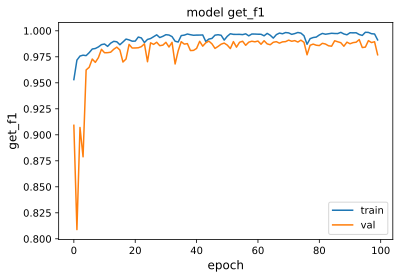

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     31676
           1       0.57      0.91      0.70      2191

    accuracy                           0.95     33867
   macro avg       0.78      0.93      0.83     33867
weighted avg       0.97      0.95      0.95     33867

[[30150  1526]
 [  201  1990]]


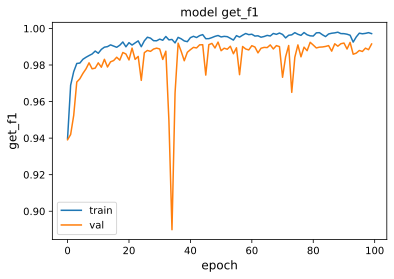

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     36212
           1       0.80      0.76      0.78      1646

    accuracy                           0.98     37858
   macro avg       0.90      0.88      0.89     37858
weighted avg       0.98      0.98      0.98     37858

[[35905   307]
 [  392  1254]]


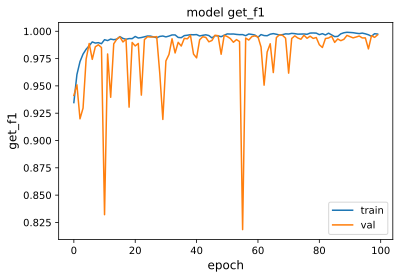

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     34275
           1       0.61      1.00      0.76       959

    accuracy                           0.98     35234
   macro avg       0.81      0.99      0.87     35234
weighted avg       0.99      0.98      0.98     35234

[[33670   605]
 [    3   956]]


In [6]:
for i in range(0,5):
    
    X_train,y_train,X_test = preprocess_data(X_train_unificado[i], y_train_unificado[i],X_test_unificado[i])
    y_test = y_test_unificado[i]

    input_shape=(X_train[0].shape)
    # As classes da rede neural devem ser sequenciais (0,1,2..)
    y_train[y_train==2] = 1
    y_test = np.array(y_test)
    y_test[y_test==2] = 1
    
    num_classes = len(np.unique(y_train))

    clf = preprocessing.LabelBinarizer()
    clf.fit(y_train)
    y_train = clf.transform(y_train)
    
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(1, activation="sigmoid")(gap)
    
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)    
    #keras.utils.plot_model(model, show_shapes=True)
    epochs = 100
    batch_size = 128

    callbacks = [
    keras.callbacks.ModelCheckpoint(
    "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=0),
    ]
    model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[get_f1],
    )
    history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    #callbacks=callbacks,
    validation_split=0.2,
    verbose=0,
    )
    
    metric = "get_f1"
    
    plt.figure()
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric])
    plt.title("model " + metric)
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val"], loc="best")
    plt.show()
    plt.close()    
    
    #model = keras.models.load_model("best_model.h5")

    y_pred = model.predict(X_test) 

    y_pred[ np.where( y_pred >= 0.8 ) ] = 1
    y_pred[ np.where( y_pred < 0.8 ) ] = 0

    print(classification_report(y_test,y_pred))

    cnf_matrix = confusion_matrix(y_test,y_pred)
    print(cnf_matrix)
    
